<a href="https://colab.research.google.com/github/BRIAN12682/Automation-Projects/blob/main/NLEMalariaMicrscopyFYPv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vi- t


In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Updated folder paths
img_dir = '/content/drive/MyDrive/DATASETS/MalariaPI/images'
annotation_dir = '/content/drive/MyDrive/DATASETS/MalariaPI/annotation'


In [ ]:
import os

# Path to your annotations directory
annotation_dir = '/content/drive/MyDrive/DATASETS/MalariaPI/annotation'

# List XML files and select the first one
xml_files = [f for f in os.listdir(annotation_dir) if f.endswith('.xml')]
first_xml_file = xml_files[0]

# Print the content of the first XML file
with open(os.path.join(annotation_dir, first_xml_file), 'r') as file:
    for i in range(10):  # Print the first 10 lines
        print(file.readline().strip())


<annotation>
<source>
<database>Makerere laboratory images database</database>
<annotation>Makerere medical school/Mulago Hospital</annotation>
<image></image>
<flickrid></flickrid>
</source>
<owner>
<flickrid></flickrid>
<name>unknown</name>


In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import os
import xml.etree.ElementTree as ET
import torch

class MalariaDataset(Dataset):
    def __init__(self, img_dir, annotation_dir, transform=None):
        self.img_dir = img_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.annotations = self.load_annotations()

    def load_annotations(self):
        annotations = []
        for file in os.listdir(self.annotation_dir):
            if file.endswith('.xml'):
                tree = ET.parse(os.path.join(self.annotation_dir, file))
                root = tree.getroot()
                image_filename = file.replace('.xml', '.jpg')  # Assuming the image file matches the XML file name
                image_path = os.path.join(self.img_dir, image_filename)
                image = Image.open(image_path).convert('RGB')

                objects = []
                for obj in root.findall('object'):
                    objects.append({
                        'xmin': float(obj.find('bndbox/xmin').text),
                        'ymin': float(obj.find('bndbox/ymin').text),
                        'xmax': float(obj.find('bndbox/xmax').text),
                        'ymax': float(obj.find('bndbox/ymax').text),
                        'label': obj.find('name').text  # Adjust label as needed
                    })

                annotations.append({
                    'image': image,
                    'objects': objects,
                    'infected': 1 if objects else 0  # 1 if there are pathogens, otherwise 0
                })
        return annotations

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image = annotation['image']
        if self.transform:
            image = self.transform(image)

        boxes = [[obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax']] for obj in annotation['objects']]
        labels = [0 for _ in annotation['objects']]  # Assuming '0' for pathogen

        target = {
            'boxes': torch.tensor(boxes),
            'labels': torch.tensor(labels),
            'infected': torch.tensor(annotation['infected'])
        }

        return image, target

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img_dir = '/content/drive/MyDrive/DATASETS/MalariaPI/images'
annotation_dir = '/content/drive/MyDrive/DATASETS/MalariaPI/annotation'
dataset = MalariaDataset(img_dir, annotation_dir, transform=transform)


In [ ]:
from torch.utils.data._utils.collate import default_collate

def custom_collate_fn(batch):
    # Separate data and targets
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Use default collate for data (images)
    data = default_collate(data)

    # Targets need custom handling:
    # Convert each attribute of targets to separate lists that can be processed individually
    boxes = [target['boxes'] for target in targets]
    labels = [target['labels'] for target in targets]
    infected = torch.stack([target['infected'] for target in targets])

    return data, {'boxes': boxes, 'labels': labels, 'infected': infected}

In [ ]:
train_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)

In [ ]:
import torch
from torchvision.models import vit_b_16, ViT_B_16_Weights
import torch.optim as optim
import torch.nn as nn
from torch.utils.data.dataset import random_split
from sklearn.metrics import accuracy_score

# Load the pretrained Vision Transformer model with specified weights
model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

# Adjust the classifier to output bounding boxes + 1 binary output for classification
num_boxes = len(dataset[0][1]['boxes'])  # Assuming this is how you calculate number of boxes
model.heads.head = nn.Linear(model.heads.head.in_features, 4 * num_boxes + 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

# Split dataset into train and validation sets
num_train = int(len(dataset) * 0.8)
num_val = len(dataset) - num_train
train_dataset, val_dataset = random_split(dataset, [num_train, num_val])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate_fn)

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    with torch.no_grad():
        predicted = outputs.sigmoid() > 0.5
        accuracy = accuracy_score(labels.cpu(), predicted.cpu())
    return accuracy

# Training and Validation Loops
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = []

    for images, targets in train_loader:
        images = images.to(device)
        infected_labels = targets['infected'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        predicted_infected = outputs[:, -1]
        loss = criterion(predicted_infected, infected_labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        acc = calculate_accuracy(predicted_infected, infected_labels)
        train_accuracy.append(acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_accuracy = []
    for images, targets in val_loader:
        images = images.to(device)
        infected_labels = targets['infected'].to(device)

        with torch.no_grad():
            outputs = model(images)
            predicted_infected = outputs[:, -1]
            loss = criterion(predicted_infected, infected_labels.float())
            val_loss += loss.item()
            acc = calculate_accuracy(predicted_infected, infected_labels)
            val_accuracy.append(acc)

    # Averaging the loss and accuracy over all batches
    train_loss /= len(train_loader)
    train_acc = sum(train_accuracy) / len(train_accuracy)
    val_loss /= len(val_loader)
    val_acc = sum(val_accuracy) / len(val_accuracy)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')


Epoch 1, Train Loss: 0.3665140227882911, Train Acc: 0.8909426987060998, Val Loss: 0.341759392991662, Val Acc: 0.8952205882352942
Epoch 2, Train Loss: 0.3430692792668691, Train Acc: 0.8946395563770795, Val Loss: 0.3538368192008313, Val Acc: 0.8952205882352942
Epoch 3, Train Loss: 0.3420700295148297, Train Acc: 0.8946395563770795, Val Loss: 0.3400104294585831, Val Acc: 0.8952205882352942
Epoch 4, Train Loss: 0.3408363257877377, Train Acc: 0.8946395563770795, Val Loss: 0.33693507138420553, Val Acc: 0.8952205882352942
Epoch 5, Train Loss: 0.339507989130928, Train Acc: 0.8946395563770795, Val Loss: 0.3463168254341273, Val Acc: 0.8952205882352942
Epoch 6, Train Loss: 0.3403387212172123, Train Acc: 0.8946395563770795, Val Loss: 0.3387052994221449, Val Acc: 0.8952205882352942


## Saving the Model

In [ ]:
import h5py
import torch

# Function to save PyTorch model as .h5
def save_model_to_h5(model, filepath):
    # Open an h5 file to write
    with h5py.File(filepath, 'w') as h5f:
        for name, param in model.named_parameters():
            # Convert parameter data to numpy and save it under the parameter's name
            h5f.create_dataset(name, data=param.cpu().numpy())

# Assuming the model is already trained and on 'device'
model_path = '/content/drive/My Drive/DATASETS/MalariaPI/vit_model.h5'
save_model_to_h5(model, model_path)


# VI-t TESTING

Infected score: 0.8762235641479492
Number of pathogens detected: 0


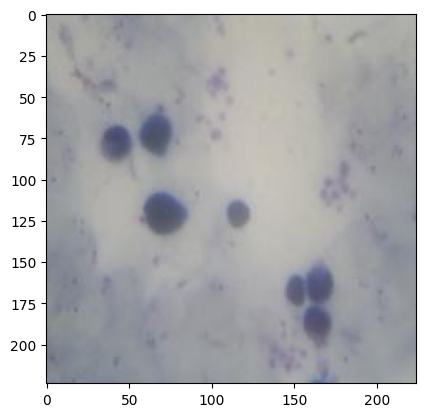

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the same transform as used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def load_image(image_path):
    # Load an image
    image = Image.open(image_path).convert('RGB')
    # Apply the transformation
    image = transform(image)
    return image

def predict_image(model, image_tensor, device):
    # Ensure model is in eval mode
    model.eval()
    # Add a batch dimension
    image_tensor = image_tensor.unsqueeze(0).to(device)
    # Perform prediction
    with torch.no_grad():
        outputs = model(image_tensor)
    return outputs

def draw_bounding_boxes(image, outputs, threshold=0.5):
    # Apply sigmoid since the outputs are logits
    outputs = torch.sigmoid(outputs[0])
    num_boxes = (outputs.size(0) - 1) // 4
    infected = outputs[-1]
    print(f"Infected score: {infected.item()}")

    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))
    count = 0

    for i in range(num_boxes):
        start = i * 4
        score = outputs[start:start+4]
        if score[0].item() > threshold:  # Assume a threshold to determine if box is valid
            count += 1
            rect = patches.Rectangle((score[1].item(), score[2].item()), score[3].item() - score[1].item(), score[4].item() - score[2].item(), linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    print(f"Number of pathogens detected: {count}")
    plt.show()

# Example usage
image_path = '/content/drive/MyDrive/DATASETS/MalariaPI/images/plasmodium-0000.jpg'
image_tensor = load_image(image_path)
outputs = predict_image(model, image_tensor, device)
draw_bounding_boxes(image_tensor, outputs)

# gpt-3

In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.7 MB/s eta 0:00:00


In [ ]:
import openai

def generate_gpt3_prompt(image_tensor, outputs, threshold=0.5):
    # Apply sigmoid since the outputs are logits
    outputs = torch.sigmoid(outputs[0])
    num_boxes = (outputs.size(0) - 1) // 4
    infected = outputs[-1].item()

    prompt = "Explain an image showing "
    if infected < threshold:
        prompt += "no signs of infection."
    else:
        prompt += f"signs of infection with {num_boxes} pathogens detected. "
        prompt += "The pathogens are located at: "

        for i in range(num_boxes):
            start = i * 4
            box = outputs[start:start+4]
            if box[0].item() > threshold:
                xmin, ymin, xmax, ymax = box[1].item(), box[2].item(), box[3].item(), box[4].item()
                prompt += f"Box {i+1} from (xmin: {xmin:.2f}, ymin: {ymin:.2f}) to (xmax: {xmax:.2f}, ymax: {ymax:.2f}), "

        prompt = prompt.strip(", ")

    return prompt


In [ ]:
def get_gpt3_explanation(prompt):
    openai.api_key = 'your-api-key'  # Ensure you use your actual API key here

    response = openai.Completion.create(
        engine="text-davinci-002",
        prompt=prompt,
        max_tokens=150
    )
    return response.choices[0].text

# Example usage/path/to/your/image.jpg'
image_path = '/content/drive/MyDrive/DATASETS/MalariaPI/images/plasmodium-0000.jpg'
image_tensor = load_image(image_path)
outputs = predict_image(model, image_tensor, device)
prompt = generate_gpt3_prompt(image_tensor, outputs)
explanation = get_gpt3_explanation(prompt)
print("GPT-3 Explanation:", explanation)


APIRemovedInV1: 

You tried to access openai.Completion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742
